In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

In [2]:
train_df = pd.read_csv("./jinnan_round1_train_20181227.csv", encoding = 'gb18030')
test_df = pd.read_csv("./jinnan_round1_testA_20181227.csv", encoding = 'gb18030')

In [3]:
train_df['A21'] = train_df['A21'].fillna(train_df['A21'].median())
train_df['B1'] = train_df['B1'].fillna(train_df['B1'].median())
train_df['B8'] = train_df['B8'].fillna(train_df['B8'].median())
train_df['B12'] = train_df['B12'].fillna(train_df['B12'].median())
def processError(df):
    if df == '1900/3/10 0:00':
        return 70
    return df
train_df['A25'] = train_df['A25'].apply(lambda x: processError(x))
train_df['A25'] = train_df['A25'].fillna(train_df['A25'].median())
train_df['A23'] = train_df['A23'].fillna(train_df['A23'].median())
train_df['B2'] = train_df['B2'].fillna(train_df['B2'].median())
train_df['B3'] = train_df['B3'].fillna(train_df['B3'].median())
train_df['B13'] = train_df['B13'].fillna(train_df['B13'].median())

In [4]:
test_df['A25'] = test_df['A25'].fillna(train_df['A25'].median())
test_df['A27'] = test_df['A27'].fillna(train_df['A27'].median())
test_df['B1'] = test_df['B1'].fillna(train_df['B1'].median())

In [5]:
views = []
for col in train_df.columns:
    views.append((col, train_df[col].nunique(), train_df[col].isnull().sum() * 100 / train_df.shape[0], train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, train_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,96,96.991404,float64
7,A7,75,89,89.326648,object
8,A8,8,89,89.326648,float64
39,B11,37,60,60.816619,object
38,B10,180,17,17.478510,object
3,A3,3,3,95.702006,float64
0,sample id,1396,0,0.071633,object
33,B5,60,0,17.550143,object
26,A26,88,0,18.982808,object
27,A27,13,0,45.128940,int64


In [6]:
views = []
for col in test_df.columns:
    views.append((col, test_df[col].nunique(), test_df[col].isnull().sum() * 100 / test_df.shape[0], test_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, test_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,98,98.000000,float64
7,A7,15,88,88.000000,object
8,A8,2,88,88.000000,float64
39,B11,11,59,59.333333,object
38,B10,50,14,14.666667,object
3,A3,2,2,97.333333,float64
0,sample id,150,0,0.666667,object
32,B4,51,0,20.666667,object
26,A26,41,0,21.333333,object
27,A27,11,0,48.000000,float64


In [7]:
for df in [train_df, test_df]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

features = list(train_df.columns)
for col in train_df.columns:
    rate = train_df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        features.remove(col)
train_df = train_df[features]
features.remove('score')
test_df = test_df[features]

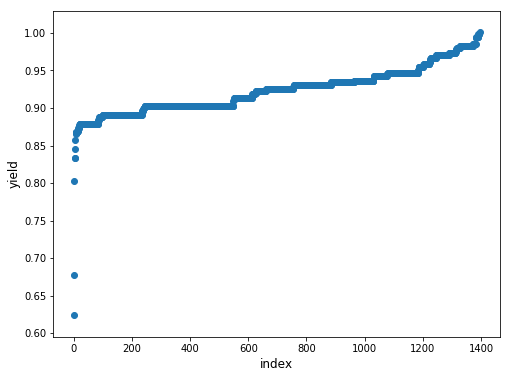

In [8]:
target_col = 'score'
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

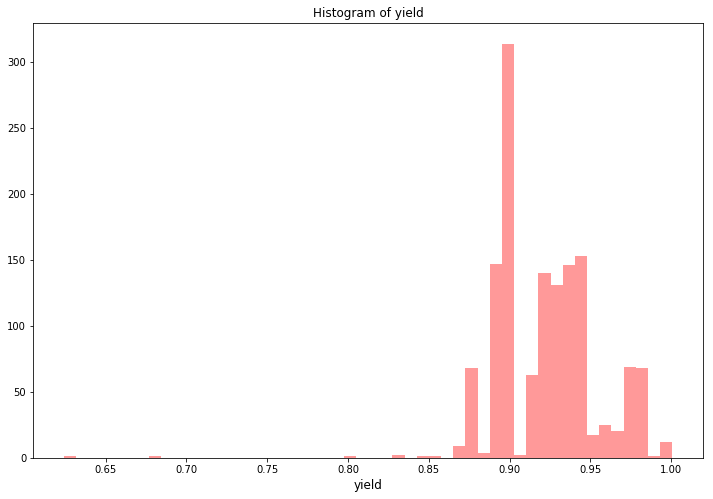

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [10]:
train_df = train_df[train_df[target_col]>0.87]

In [11]:
def TimeToInt(str, previous = 0):
    now = 0
    previous = 0
    try:
        time = str.split(":")
        now = int(time[0]) * 60 + int(time[1])
        if now < previous:
            now += 24 * 60
    except:
        return previous + 60
    return now

def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)
        elif t==-1:
            return -1
        else:
            return 0
    try:
        tm = int(t)*3600+int(m)*60+int(s)
    except:
        return -1
    return tm

def getInt(str):
    val = str.split(":")
    return int(val[0]) * 60 + int(val[1])

def TimeToDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1
    try:
        duration = int(eh)*60+int(em)-int(sm)-int(sh)*60
        if duration < 0:
            duration += 24 * 60
        return duration
    except:
        return 0

def Between(t1, t2):
    duration = 0
    try:
        duration = t2 - t1
    except:
        duration = 0
    return duration

In [12]:
for df in [train_df, test_df]:
    df['A5'] = df['A5'].apply(lambda x: TimeToInt(x))
    df['A7'] = df['A7'].apply(lambda x: TimeToInt(x))
    df['A9'] = df.apply(lambda x: TimeToInt(x.A9, x.A5), axis = 1)
    df['A11'] = df.apply(lambda x: TimeToInt(x.A11, x.A9), axis = 1)
    df['A14'] = df.apply(lambda x: TimeToInt(x.A14, x.A11), axis = 1)
    df['A16'] = df.apply(lambda x: TimeToInt(x.A16, x.A14), axis = 1)
    df['A24'] = df.apply(lambda x: TimeToInt(x.A24, x.A16), axis = 1)
    df['A26'] = df.apply(lambda x: TimeToInt(x.A26, x.A24), axis = 1)
    df['B5'] = df.apply(lambda x: TimeToInt(x.B5, x.A26), axis = 1)
    df['B7'] = df.apply(lambda x: TimeToInt(x.B7, x.B5), axis = 1)
#for df in [train_df, test_df]:
#    for col in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
#        df[col] = df.apply(lambda df: timeTranSecond(df[col]), axis=1)

In [13]:
for df in [train_df, test_df]:
    for col in ['A20', 'A28', 'B4', 'B9', 'B10', 'B11']:
        df[col] = df.apply(lambda df: TimeToDuration(df[col]), axis=1)

In [14]:
train_df.head()

,sample id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,score
0,sample_1528,810,38.0,60,NaN,930,100,990,102,1050,103.0,1110,104.0,300,30,9.0,1320,75,1350,70,30,350.0,60,480,65,690,45.0,90,90,0,800.0,400,0.879
1,sample_1698,840,29.0,60,NaN,960,101,1020,103,1080,104.0,1140,105.0,200,60,9.0,1200,80,1260,73,60,320.0,60,1380,80,360,45.0,90,90,60,1200.0,400,0.902
2,sample_639,840,29.0,60,NaN,960,102,1020,103,1080,104.0,1140,105.0,200,30,9.0,1200,79,1260,73,60,320.0,60,1380,80,60,45.0,90,90,60,1200.0,400,0.936
3,sample_483,90,38.0,60,NaN,180,100,240,102,300,103.0,360,104.0,200,30,10.0,450,70,480,78,60,290.0,60,930,65,1080,45.0,90,90,0,800.0,400,0.902
4,sample_617,1320,29.0,60,NaN,0,101,60,103,120,104.0,180,105.0,200,60,9.0,240,80,300,73,60,320.0,60,420,80,540,45.0,90,90,60,1200.0,420,0.983


In [15]:
target = train_df['score']
del train_df['score']
data = pd.concat([train_df,test_df],axis=0,ignore_index=True)
data = data.fillna(-1)

cate_columns = [f for f in data.columns if f != 'sample id']

#label encoder
for f in cate_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train_df.shape[0]]
test  = data[train_df.shape[0]:]

In [16]:
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
train.head()

,sample id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,target,intTarget_0.0,intTarget_1.0,intTarget_2.0,intTarget_3.0,intTarget_4.0
0,sample_1528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.879,1,0,0,0,0
1,sample_1698,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,0,0,0,1,1,0,0.902,0,1,0,0,0
2,sample_639,1,1,0,0,1,2,1,1,1,1,1,1,1,0,0,1,2,1,1,1,1,0,1,1,2,0,0,0,1,1,0,0.936,0,0,1,0,0
3,sample_483,2,0,0,0,2,0,2,0,2,0,2,0,1,0,1,2,3,2,2,1,2,0,2,0,3,0,0,0,0,0,0,0.902,0,1,0,0,0
4,sample_617,3,1,0,0,3,1,3,1,3,1,3,1,1,1,0,3,1,3,1,1,1,0,3,1,4,0,0,0,1,1,1,0.983,0,0,0,0,1


In [17]:
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_features = []
for f1 in cate_columns:
    for f2 in li:
        col_name = f1+"_"+f2+'_mean'
        mean_features.append(col_name)
        order_label = train.groupby([f1])[f2].mean()
        for df in [train, test]:
            df[col_name] = df[f1].map(order_label)

train.drop(li, axis=1, inplace=True)

In [18]:
train.head()

,sample id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,target,A5_intTarget_0.0_mean,A5_intTarget_1.0_mean,A5_intTarget_2.0_mean,A5_intTarget_3.0_mean,A5_intTarget_4.0_mean,A6_intTarget_0.0_mean,A6_intTarget_1.0_mean,A6_intTarget_2.0_mean,A6_intTarget_3.0_mean,A6_intTarget_4.0_mean,A7_intTarget_0.0_mean,A7_intTarget_1.0_mean,A7_intTarget_2.0_mean,A7_intTarget_3.0_mean,A7_intTarget_4.0_mean,A8_intTarget_0.0_mean,A8_intTarget_1.0_mean,A8_intTarget_2.0_mean,A8_intTarget_3.0_mean,A8_intTarget_4.0_mean,A9_intTarget_0.0_mean,A9_intTarget_1.0_mean,A9_intTarget_2.0_mean,A9_intTarget_3.0_mean,A9_intTarget_4.0_mean,A10_intTarget_0.0_mean,A10_intTarget_1.0_mean,A10_intTarget_2.0_mean,A10_intTarget_3.0_mean,A10_intTarget_4.0_mean,A11_intTarget_0.0_mean,A11_intTarget_1.0_mean,A11_intTarget_2.0_mean,A11_intTarget_3.0_mean,A11_intTarget_4.0_mean,A12_intTarget_0.0_mean,A12_intTarget_1.0_mean,A12_intTarget_2.0_mean,A12_intTarget_3.0_mean,A12_intTarget_4.0_mean,A14_intTarget_0.0_mean,A14_intTarget_1.0_mean,A14_intTarget_2.0_mean,A14_intTarget_3.0_mean,A14_intTarget_4.0_mean,A15_intTarget_0.0_mean,A15_intTarget_1.0_mean,A15_intTarget_2.0_mean,A15_intTarget_3.0_mean,A15_intTarget_4.0_mean,A16_intTarget_0.0_mean,A16_intTarget_1.0_mean,A16_intTarget_2.0_mean,A16_intTarget_3.0_mean,A16_intTarget_4.0_mean,A17_intTarget_0.0_mean,A17_intTarget_1.0_mean,A17_intTarget_2.0_mean,A17_intTarget_3.0_mean,A17_intTarget_4.0_mean,A19_intTarget_0.0_mean,A19_intTarget_1.0_mean,A19_intTarget_2.0_mean,A19_intTarget_3.0_mean,A19_intTarget_4.0_mean,A20_intTarget_0.0_mean,A20_intTarget_1.0_mean,A20_intTarget_2.0_mean,A20_intTarget_3.0_mean,A20_intTarget_4.0_mean,A22_intTarget_0.0_mean,A22_intTarget_1.0_mean,A22_intTarget_2.0_mean,A22_intTarget_3.0_mean,A22_intTarget_4.0_mean,A24_intTarget_0.0_mean,A24_intTarget_1.0_mean,A24_intTarget_2.0_mean,A24_intTarget_3.0_mean,A24_intTarget_4.0_mean,A25_intTarget_0.0_mean,A25_intTarget_1.0_mean,A25_intTarget_2.0_mean,A25_intTarget_3.0_mean,A25_intTarget_4.0_mean,A26_intTarget_0.0_mean,A26_intTarget_1.0_mean,A26_intTarget_2.0_mean,A26_intTarget_3.0_mean,A26_intTarget_4.0_mean,A27_intTarget_0.0_mean,A27_intTarget_1.0_mean,A27_intTarget_2.0_mean,A27_intTarget_3.0_mean,A27_intTarget_4.0_mean,A28_intTarget_0.0_mean,A28_intTarget_1.0_mean,A28_intTarget_2.0_mean,A28_intTarget_3.0_mean,A28_intTarget_4.0_mean,B1_intTarget_0.0_mean,B1_intTarget_1.0_mean,B1_intTarget_2.0_mean,B1_intTarget_3.0_mean,B1_intTarget_4.0_mean,B4_intTarget_0.0_mean,B4_intTarget_1.0_mean,B4_intTarget_2.0_mean,B4_intTarget_3.0_mean,B4_intTarget_4.0_mean,B5_intTarget_0.0_mean,B5_intTarget_1.0_mean,B5_intTarget_2.0_mean,B5_intTarget_3.0_mean,B5_intTarget_4.0_mean,B6_intTarget_0.0_mean,B6_intTarget_1.0_mean,B6_intTarget_2.0_mean,B6_intTarget_3.0_mean,B6_intTarget_4.0_mean,B7_intTarget_0.0_mean,B7_intTarget_1.0_mean,B7_intTarget_2.0_mean,B7_intTarget_3.0_mean,B7_intTarget_4.0_mean,B8_intTarget_0.0_mean,B8_intTarget_1.0_mean,B8_intTarget_2.0_mean,B8_intTarget_3.0_mean,B8_intTarget_4.0_mean,B9_intTarget_0.0_mean,B9_intTarget_1.0_mean,B9_intTarget_2.0_mean,B9_intTarget_3.0_mean,B9_intTarget_4.0_mean,B10_intTarget_0.0_mean,B10_intTarget_1.0_mean,B10_intTarget_2.0_mean,B10_intTarget_3.0_mean,B10_intTarget_4.0_mean,B11_intTarget_0.0_mean,B11_intTarget_1.0_mean,B11_intTarget_2.0_mean,B11_intTarget_3.0_mean,B11_intTarget_4.0_mean,B12_intTarget_0.0_mean,B12_intTarget_1.0_mean,B12_intTarget_2.0_mean,B12_intTarget_3.0_mean,B12_intTarget_4.0_mean,B14_intTarget_0.0_mean,B14_intTarget_1.0_mean,B14_intTarget_2.0_mean,B14_intTarget_3.0_mean,B14_intTarget_4.0_mean
0,sample_1528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.879,0.285714,0.285714,0.428571,0.000000,0.000000,0.157895,0.210526,0.438596,0.105263,0.070175,0.161395,0.284672,0.396594,0.090024,0.057583,0.161526,0.284903,0.396916,0.090097,0.056818,0.058824,0.470588,0.235294,0.117647,0.117647,0.177743,0.272025,0.387944,0.092736,0.052550,0.058824,0.47

In [19]:
train.drop(['sample id','target'], axis=1, inplace=True)
test = test[train.columns]
X_train = train.values
y_train = target.values
X_test = test.values

In [20]:
y_train = target.values

param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

# 五折交叉验证
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    clf = lgb.train(param, 
                    trn_data, 
                    num_boost_round=10000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 200, 
                    early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))


fold n°1
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 0.000222105	valid_1's l2: 0.000246555
[400]	training's l2: 0.000165887	valid_1's l2: 0.000208682
[600]	training's l2: 0.000141516	valid_1's l2: 0.000198434
[800]	training's l2: 0.000128206	valid_1's l2: 0.000195339
[1000]	training's l2: 0.000119562	valid_1's l2: 0.000193651
[1200]	training's l2: 0.000113406	valid_1's l2: 0.00019297
[1400]	training's l2: 0.000108588	valid_1's l2: 0.000192351
[1600]	training's l2: 0.000105031	valid_1's l2: 0.000192333
[1800]	training's l2: 0.00010222	valid_1's l2: 0.000192264
[2000]	training's l2: 9.97293e-05	valid_1's l2: 0.000192087
[2200]	training's l2: 9.7716e-05	valid_1's l2: 0.000192262
Early stopping, best iteration is:
[2033]	training's l2: 9.93496e-05	valid_1's l2: 0.000191926
fold n°2
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 0.00021762	valid_1's l2: 0.000247561
[400]	training's l2: 0.000158581	valid_1's l2: 0.0

In [21]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=200, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422934	valid_data-rmse:0.423824
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[200]	train-rmse:0.15672	valid_data-rmse:0.157604
[400]	train-rmse:0.059558	valid_data-rmse:0.060209
[600]	train-rmse:0.024846	valid_data-rmse:0.026229
[800]	train-rmse:0.012934	valid_data-rmse:0.016105
[1000]	train-rmse:0.009055	valid_data-rmse:0.013747
[1200]	train-rmse:0.00772	valid_data-rmse:0.013291
[1400]	train-rmse:0.007119	valid_data-rmse:0.013224
[1600]	train-rmse:0.006773	valid_data-rmse:0.013246
Stopping. Best iteration:
[1469]	train-rmse:0.006979	valid_data-rmse:0.013214

fold n°2
[0]	train-rmse:0.424044	valid_data-rmse:0.419358
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[200]	train-rmse:0.157094	valid_data-rmse:0.153919
[400]	train-rmse:0.059567	valid_

In [22]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.8f}".format(mean_squared_error(target.values, oof_stack)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 0.00018079


In [23]:
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("submission.csv", index=False, header=None)